In [38]:
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, to_ordinal
from tensorflow.keras.models import load_model
#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import keras_tuner as kt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

print(tf.__version__)

2.13.0


In [39]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize.
train_images = (train_images / 255)
test_images = (test_images / 255)

# Flatten.
# train_images = train_images.reshape((-1, 784)) # можно использовать np.ravel()
# test_images = test_images.reshape((-1, 784))

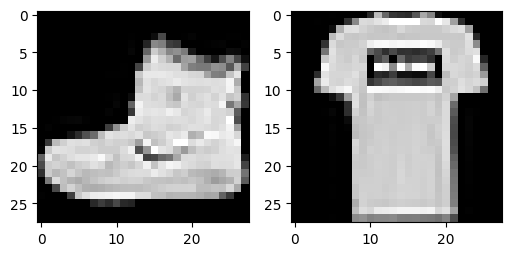

In [24]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_images[1], cmap='gray')

In [40]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [49]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='tanh', name='hiden_three'),
    keras.layers.Dense(64, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, activation='softmax', name='output')
])
config = model.get_config()
model.save_weights('fashion_weights.h5')

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layers_flatten (Flatten)    (None, 784)               0         
                                                                 
 hiden_one (Dense)           (None, 256)               200960    
                                                                 
 hiden_two (Dense)           (None, 128)               32896     
                                                                 
 hiden_three (Dense)         (None, 64)                8256      
                                                                 
 hiden_four (Dense)          (None, 64)                4160      
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 246922 (964.54 KB)
Trainable params: 246

In [28]:
#rm -rf ./logs/

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 - 1s - loss: 0.3242 - accuracy: 0.8952 - 766ms/epoch - 2ms/step

Test accuracy: 0.8952000141143799
313/313 [==============================] - 1s 2ms/step


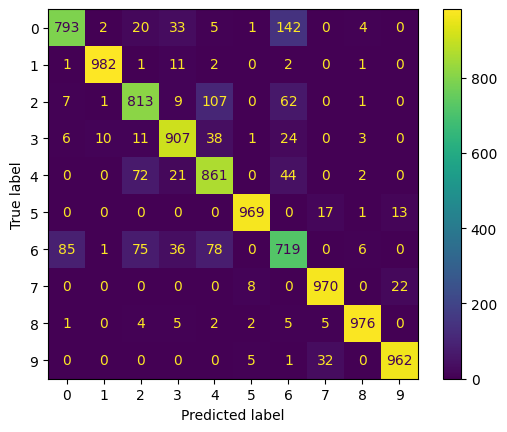

In [50]:
model = model.from_config(config)
model.load_weights('fashion_weights.h5')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size = 350, epochs=50, verbose=0)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

In [51]:
def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
  precision = precision_score(y_true, y_pred, labels=labels, average=None)
  recall = recall_score(y_true, y_pred, labels=labels, average=None)
  for i, el in enumerate(zip(precision, recall)):
    print(f'Класс - {i}, точность - {el[0]:.3f}, полнота - {el[1]:.3f}')

In [52]:
recall_precision(test_labels, y_pred)

Класс - 0, точность - 0.888, полнота - 0.793
Класс - 1, точность - 0.986, полнота - 0.982
Класс - 2, точность - 0.816, полнота - 0.813
Класс - 3, точность - 0.887, полнота - 0.907
Класс - 4, точность - 0.788, полнота - 0.861
Класс - 5, точность - 0.983, полнота - 0.969
Класс - 6, точность - 0.720, полнота - 0.719
Класс - 7, точность - 0.947, полнота - 0.970
Класс - 8, точность - 0.982, полнота - 0.976
Класс - 9, точность - 0.965, полнота - 0.962


Что было сделано:
 - Изменял оптимизатор (в основном использовал SGD, другие даже не пробовал - очевидно результат будет хуже);
 - Изменял количество слоев, использовал Dropout 0.2/0.3;
 - Изменял функции активации (в основном relu, softmax, tanh, softplus) в разных сочетаниях;
 - Изменял размер батчей, количество эпох;

 Выводы:
- С помощью изменения гиперпараметров не удалось увеличить общую эффективность модели, в первую очередь нас беспокоил 6 класс с самым низким показателем. Его точность увеличить не удалось, при внесении изменений она только падала, что касается других классов она плавала +- 0.05. Таким образом, улучшения модели можно добиться только иными способами, изолированным изменением параметров результата достичь не удасться.